import sys
sys.path.append('e:/ViT2STInterp')

In [1]:
import ocean_data_processor,Input_data_pro_show,output_data_pro_show
from ocean_data_processor import create_dataloader
from Input_data_pro_show import show_sequence, resize_tensor
from output_data_pro_show import rearange_output
# Define the directory containing your NetCDF files
data_directory = 'G:/YuJinYuan-Experiment/MODIS'

# Create a dataloader
dataloader = create_dataloader(
    directory=data_directory,
    batch_size=1,
    len_frame=1,
    use_random_mask=False,
    mask_ratio=0.1,
    shuffle=False,
    scale_factor=1.0
)

# Iterate through the dataloader
# for batch_idx, (data, mask, meta_data) in enumerate(dataloader):
#     print(f"Batch {batch_idx}")
#     print(f"Data shape: {data.shape}")
#     print(f"Mask shape: {mask.shape}")
#     print(f"Meta data shape: {meta_data.shape}")

In [2]:
import torch
import torch.nn.functional as F
num_frames_to_show = 24
now_frame = 0
orig_frames = []
masked_frames = []
meta_data_frames = []

for data_sample, mask_sample, meta_data in dataloader:
    # Resize tensors
    data_sample = resize_tensor(data_sample, (50, 50), 'bilinear', False)
    mask_sample = mask_sample.view(-1, mask_sample.shape[-3], mask_sample.shape[-2], mask_sample.shape[-1])
    mask_sample = F.interpolate(mask_sample, size=(50, 50), mode='bilinear', align_corners=False)
    mask_sample = mask_sample.view(mask_sample.shape[-3], mask_sample.shape[-2], mask_sample.shape[-1])
    meta_data = resize_tensor(meta_data, (50, 50), 'bilinear', False)

    # Collect frames within the valid range
    if now_frame < num_frames_to_show:
        orig_frames.append(data_sample[:, :, :, :, :].detach())
        masked_frames.append(mask_sample[:, :].detach())
        meta_data_frames.append(meta_data[:, :, :, :, :].detach())
        now_frame = now_frame + 1
    else:
        break

# Convert lists to tensors
orig_frames = torch.cat(orig_frames, dim=1)
masked_frames = torch.cat(masked_frames, dim=0)
meta_data_frames = torch.cat(meta_data_frames, dim=1)

# Visualize frames
# show_sequence(orig_frames[0, :, 0, :, :], sample=6, title='Original Frames')
# show_sequence(1 - masked_frames[:, :, :], sample=6, title='Masked Frames')
# show_sequence(meta_data_frames[0, :, 0, :, :], sample=6, title='1-Meta Data Frames')


In [11]:
from transformers import VideoMAEForPreTraining, VideoMAEConfig
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the VideoMAE model for pre-training
config = VideoMAEConfig(
    image_size=50,
    patch_size=2,
    num_channels=1,
    num_frames=24,
    tubelet_size=2,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    qkv_bias=True,
    use_mean_pooling=True
)
input_tensor = orig_frames[:,:,:1,:,:].to(device)#*b (t p0) c (h p1) (w p2) 
model = VideoMAEForPreTraining(config).to(device)

# Create a mask for missing values
num_patches_per_frame = (config.image_size // config.patch_size) ** 2
#! seq_length:patch number of a tubelet
seq_length = (config.num_frames // config.tubelet_size) * num_patches_per_frame

bool_masked_pos = torch.randint(0, 2, (1, seq_length)).bool().to(device)#* Tensor (1,seq_length)
#! one tubelet only use one masking strategy

# Forward pass through the model using the preprocessed video frames
outputs = model(pixel_values=input_tensor, bool_masked_pos=bool_masked_pos)

# The output contains the loss and reconstructed patches
loss = outputs.loss
reconstructed_patches = outputs.logits

# Display the loss and shape of the reconstructed patches
print("Loss:", loss.item())
print("Reconstructed patches shape:", reconstructed_patches.shape)

Loss: 0.5122376084327698
Reconstructed patches shape: torch.Size([1, 3797, 8])


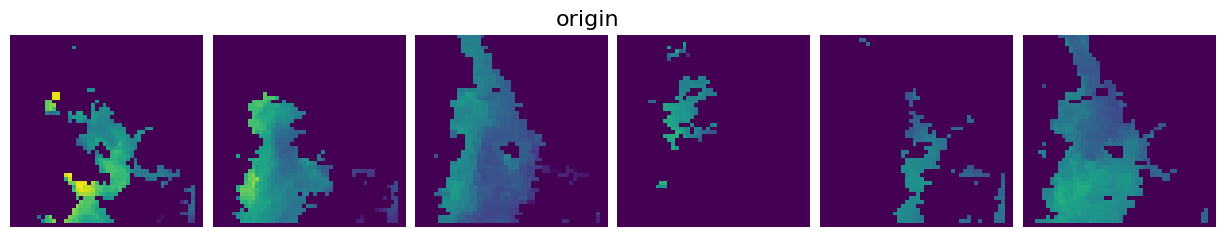

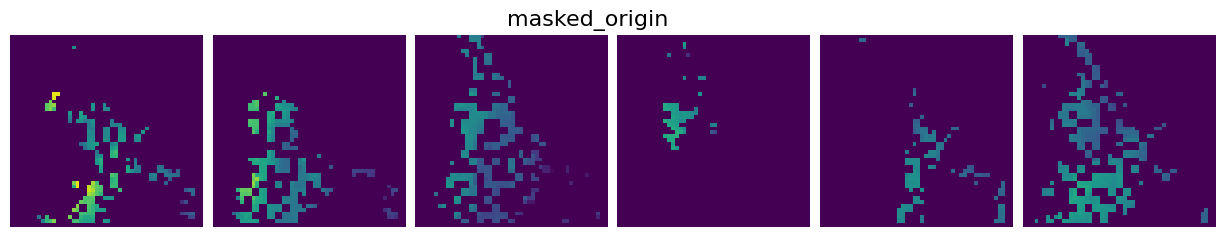

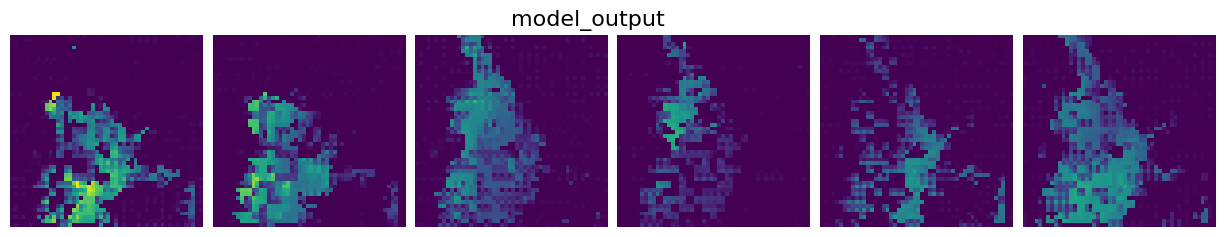

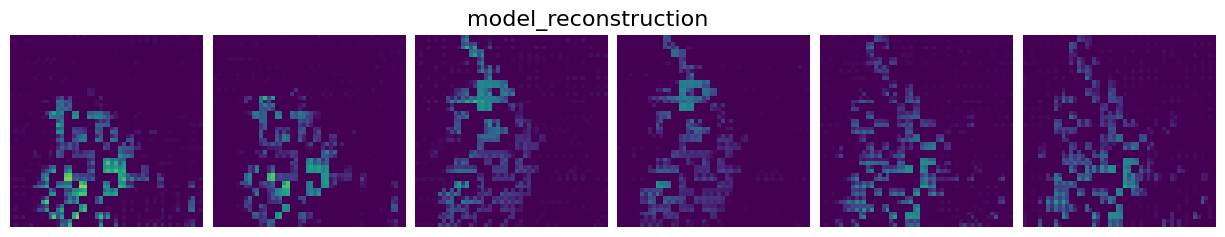

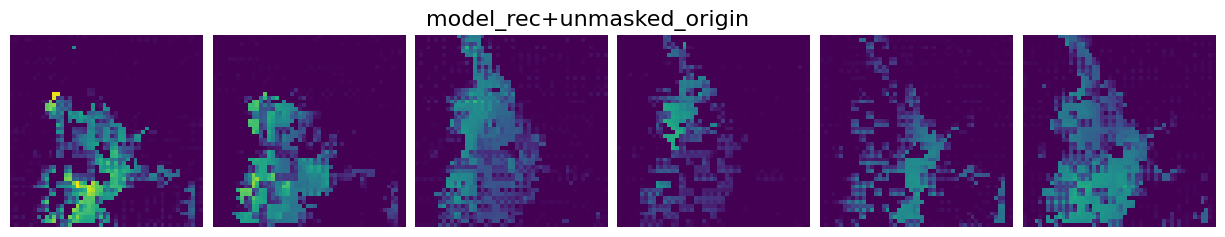

In [12]:
# Assume input_tensor, reconstructed_patches, bool_masked_pos, and config are defined
rec_img, mask = rearange_output(input_tensor, reconstructed_patches, bool_masked_pos, config)
show_sample=6
show_sequence(orig_frames[0, :, 0, :, :],sample=show_sample,title='origin')
# show_sequence(1-mask[0],sample=6)
show_sequence(orig_frames[0, :, 0, :, :]*mask[0,:,:,:,0], sample=show_sample,title='unmasked_origin')
show_sequence(rec_img[0,:,:,:,0],sample=show_sample,title='model_output')
show_sequence(rec_img[0] * (1 - mask[0]), sample=show_sample,title='model_reconstruction')
reconstructed_frames = orig_frames[0, :, 0, :, :] * mask[0,:,:,:,0] + rec_img[0,:,:,:,0] * (1 - mask[0])[:,:,:,0]
show_sequence(reconstructed_frames,sample=show_sample,title='model_rec+unmasked_origin')